In [147]:
%matplotlib notebook

# %qtconsole

import logging
import time
from importlib import reload

from matplotlib import pyplot as plt
from matplotlib import colors, cm
import numpy as np

import qcodes as qc
from qcodes.dataset.experiment_container import new_experiment

In [148]:
from pytopo.qctools import instruments as instools
from pytopo.qctools.instruments import create_inst, add2station

from pytopo.sweep.base import Nest, Chain
from pytopo.sweep.decorators import getter, setter
from pytopo.sweep import sweep, do_experiment, hardsweep, measure

# Define measurement functions

In [195]:
def setup_frq_sweep(fstart, fstop, fpts, chan='S21', bw=None, navgs=None, pwr=None):
    """
    Setup a VNA trace.
    
    assumes that a channel with name chan is already created.
    """
    vna = qc.Station.default.vna
    trace = getattr(vna.channels, chan)
    
    fvals = np.linspace(fstart, fstop, fpts)
    trace.start(fstart)
    trace.stop(fstop)
    trace.npts(fpts)
    if navgs is not None:
        trace.avg(navgs)
    if bw is not None:
        trace.bandwidth(bw)
    if pwr is not None:
        trace.power(pwr)
    trace.autoscale()
    
    if not vna.rf_power():
        vna.rf_on()
    
    return fvals

def take_trace(chan='S21', plot=False):
    """
    Get the data of a currently measured trace.
    The trace has to be setup already.
    
    Returns magnitude (in dB) and phase (in rad).
    
    If plot is true, make a simple plot of the magnitude vs frequency.
    """
    vna = qc.Station.default.vna
    trace = getattr(vna.channels, chan)
    
    fvals = np.linspace(trace.start(), trace.stop(), trace.npts())
    mag, phase = trace.trace_mag_phase()
    
    if plot:
        fig, ax = plt.subplots(1, 1)
        ax.plot(fvals*1e-9, 20*np.log10(mag))
        ax.grid(dashes=[1,1])
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('Magnitude (dBm)')
        
    return mag, phase


@hardsweep(
    ind=[('frequency', 'Hz', 'array')], 
    dep=[('amplitude', '', 'array'), ('phase', 'rad', 'array')]
)
def vna_frequency_sweep(*arg, **kw):
    """
    Measurement function for a simple VNA trace for pytopo.sweep.
    
    All arguments will be passed to setup_trace.
    Return data is as returned by take_trace.
    """
    fvals = setup_frq_sweep(*arg, **kw)
    mag, phase = take_trace(plot=False)
    
    return fvals, np.vstack((mag, phase))


@hardsweep(
    ind=[('frequency', 'Hz', 'array')], 
    dep=[('magnitude', 'dB', 'array'), ('phase', 'rad', 'array')]
)
def vna_frequency_sweep_dB(*arg, **kw):
    """
    Measurement function for a simple VNA trace for pytopo.sweep.
    
    All arguments will be passed to setup_trace.
    Return data is as returned by take_trace.
    """
    fvals = setup_frq_sweep(*arg, **kw)
    mag, phase = take_trace(plot=False)
    
    return fvals, np.vstack((20*np.log10(mag), phase))


def setup_zerospan_trace(frq, npts, chan='S21', span=1.):
    """
    Setup the VNA to measure a trace around <frq> with <npts> samples
    in a very narray frequency span.
    """
    vna = qc.Station.default.vna
    trace = getattr(vna.channels, chan)
    
    trace.center(frq)
    trace.span(span)
    trace.npts(npts)
    
    trace.autoscale()
    
    if not vna.rf_power():
        vna.rf_on()


@hardsweep(
    ind=[('iteration', '', 'array')], 
    dep=[('amplitude', '', 'array'), ('phase', 'rad', 'array')]
)
def vna_timetrace(*arg, **kw):
    """
    Measure a 'time trace', emulated by a narrow span trace with many points.
    """
    setup_zerospan_trace(*arg, **kw)
    mag, phase = take_trace(plot=False)
    
    return np.arange(mag.size), np.vstack((mag, phase))


@hardsweep(
    ind=[('iteration', '', 'array')], 
    dep=[('magnitude', 'dB', 'array'), ('phase', 'rad', 'array')]
)
def vna_timetrace(*arg, **kw):
    """
    Measure a 'time trace', emulated by a narrow span trace with many points.
    """
    setup_zerospan_trace(*arg, **kw)
    mag, phase = take_trace(plot=False)
    
    return np.arange(mag.size), np.vstack((20*np.log10(mag), phase))

# Init station

## Global variables

In [150]:
SAMPLE = "FluxoniumTest_CD20181015"

## Init instruments

In [2]:
%run -i D:/OneDrive/BF2/Code/BF2/BF2/init_station.py

In [176]:
from qcodes.instrument_drivers.rohde_schwarz.ZNB import ZNB
vna = create_inst(ZNB, 'vna', address='TCPIP::169.254.62.18::inst0::INSTR', force_new_instance=True)
station = qc.Station(vna)

from qcodes.instrument_drivers.oxford.mercuryiPS import MercuryiPS
mgnt = create_inst(MercuryiPs, 'mgnt', address='TCPIP::--::inst0::INSTR', force_new_instance=True)
station = qc.Station(mgnt)

# the VNA driver has some weird default settings. 
# Make sure here that we measure what we want
vna.clear_channels()
vna.add_channel('S21')
vna.rf_off()

Instrument vna already exists.
Connected to: Rohde-Schwarz ZNB20-2Port (serial:1311601062101971, firmware:2.90) in 0.17s


In [55]:
# check that we can take the trace correctly
# mag, phase = take_trace(plot=True)

In [109]:
from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
twpa_pump = create_inst(RohdeSchwarz_SGS100A, 'twpa_pump', address="TCPIP::169.254.167.18::inst0::INSTR")

Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110531, firmware:3.1.19.15-3.50.124.67) in 0.04s


# Testing

## Quick manual trace (without saving)

<IPython.core.display.Javascript object>


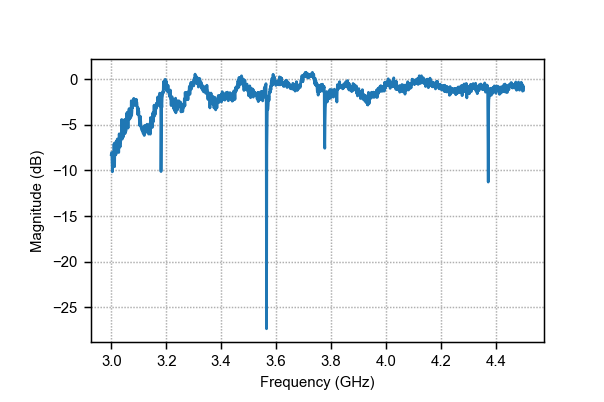

In [196]:
setup_frq_sweep(fstart=3e9, fstop=4.5e9, fpts=1501, pwr=-50)
mag, phase = take_trace(plot=True)

# Take a single VNA trace

In [84]:
sweep_obj = vna_trace(fstart=4.355e9, fstop=4.395e9, fpts=4001, chan='S21')

result = do_experiment(f"VNA/{SAMPLE}", sweep_obj, live_plot=True)

Starting experimental run with id: 30


# Power dependence

In [223]:
vna.S21.avg(10)

In [224]:
sweep_obj = sweep(vna.S21.power, np.arange(-60., -9., 5.))(
    vna_trace(fstart=4.355e9, fstop=4.395e9, fpts=4001, chan='S21', bw=1e3)
)

result = do_experiment(f"VNA_powersweep/{SAMPLE}", sweep_obj, live_plot=True)

Starting experimental run with id: 100


In [225]:
sweep_obj = sweep(vna.S21.power, np.arange(-60., -9., 5.))(
    vna_trace(fstart=3.7555e9, fstop=3.795e9, fpts=4001, chan='S21', bw=1e3)
)

result = do_experiment(f"VNA_powersweep/{SAMPLE}", sweep_obj, live_plot=True)

Starting experimental run with id: 101


In [226]:
sweep_obj = sweep(vna.S21.power, np.arange(-60., -9., 5.))(
    vna_trace(fstart=3.543e9, fstop=3.5835e9, fpts=4001, chan='S21', bw=1e3)
)

result = do_experiment(f"VNA_powersweep/{SAMPLE}", sweep_obj, live_plot=True)

Starting experimental run with id: 102


In [227]:
sweep_obj = sweep(vna.S21.power, np.arange(-60., -9., 5.))(
    vna_trace(fstart=3.159e9, fstop=3.199e9, fpts=4001, chan='S21', bw=1e3)
)

result = do_experiment(f"VNA_powersweep/{SAMPLE}", sweep_obj, live_plot=True)

Starting experimental run with id: 103


In [228]:
vna.S21.power(-50.0)
sweep_obj = vna_trace(fstart=3.0e9, fstop=5.0e9, fpts=4001, chan='S21', bw=1e3)

result = do_experiment(f"VNA/{SAMPLE}", sweep_obj, live_plot=True)

Starting experimental run with id: 104


# TWPA pump tune up

## VNA as function of pump power

In [192]:
# sweep_obj = sweep(twpa_pump.power, np.arange(2.5, 8.5, .2))(
#     vna_trace(fstart=2e9, fstop=7e9, fpts=1001, chan='S21', navgs=1)
# )

# result = do_experiment(f"VNA_vs_pump_power/{SAMPLE}", sweep_obj, live_plot=True)

## VNA as function of pump frq

In [193]:
# sweep_obj = sweep(twpa_pump.frequency, np.arange(7.7e9, 8.4e9, 10e6))(
#     vna_trace(fstart=2e9, fstop=7e9, fpts=1001, chan='S21', navgs=1)
# )

# result = do_experiment(f"VNA_vs_pump_frequency/{SAMPLE}", sweep_obj, live_plot=True)

## SNR as function of pump params

In [197]:
@getter(('signal', 'dB'), ('noise', 'dB'), ('SNR', 'dB'))
def get_SNR():
    time.sleep(0.01)
    mag, phase = take_trace(plot=False)
    sig = np.abs(mag) * np.exp(-1j*phase)
#     I, Q = sig.real, sig.imag
    lin_mean = np.abs(sig.mean())
    lin_std = np.abs(sig.std())
#     lin_mean = (I.mean()**2. + Q.mean()**2.)**.5
#     lin_std = (I.std()**2. + Q.std()**2.)**.5
    return 20*np.log10(lin_mean), 20*np.log10(lin_std), 20*np.log10(lin_mean/lin_std)

In [211]:
twpa_pump.on()
vna.S21.avg(1)
vna.S21.power(-50)
setup_zerospan_trace(4.5e9, 201)


sweep_obj = sweep(twpa_pump.frequency, np.arange(7.95e9, 8.05e9, 0.5e6))(
    sweep(twpa_pump.power, np.arange(0.0, 12.0, .1)))(
        measure(get_SNR)
)

result = do_experiment(f"TWPA_SNR/{SAMPLE}", sweep_obj, live_plot=True)

Starting experimental run with id: 91


In [199]:
twpa_pump.off()
vna.S21.avg(1)
vna.S21.power(-50)
setup_zerospan_trace(5e9, 201)


sweep_obj = sweep(twpa_pump.frequency, np.arange(7.95e9, 8.05e9, 0.5e6))(
#     sweep(twpa_pump.power, np.arange(3.0, 8.0, .1)))(
        measure(get_SNR)
)

result = do_experiment(f"TWPA_SNR/{SAMPLE}", sweep_obj, live_plot=True)

Starting experimental run with id: 87


In [201]:
runid = 86
data = qc.dataset.data_export.load_by_id(runid)

In [206]:
SNR = np.array(data.get_data('SNR'))

In [207]:
SNR.max()

34.877032895881101

# VNA vs Magnet Measurements